In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from pathlib import Path
#data_folder = Path("C:/Users/merri/OneDrive/Nan's NW/Capstone")

import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')


# import Natural Language Tookit
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import matplotlib.pyplot as plt

import re

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, Dense

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow.keras.backend as k
from tensorflow.keras.metrics import AUC

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import make_scorer, mean_squared_error

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import mean_squared_error as MSE

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

from sklearn.feature_extraction.text import CountVectorizer

from packaging import version
from tensorflow.python.client import device_lib


from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize

# for Glove tokenization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences

# SMOTE oversampling
from imblearn.over_sampling import SMOTE


In [2]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

from tensorflow.python.client import device_lib
tf.config.list_physical_devices('GPU')

device_lib.list_local_devices()

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.10.1


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 17914857362383229725
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 22385000448
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 3466538949862627378
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9"
 xla_global_id: 416903419]

In [3]:



# Download the stopwords and punkt tokenizer models
nltk.download('stopwords')
nltk.download('punkt')

# Function to determine the type of product number
def determine_number_type(s):
    if '.' in s:
        return 'float'
    elif '-' in s:
        return 'hyphenated'
    elif s.isdigit():  # checks if the string contains only numbers
        return 'numeric'
    else:
        return 'alphanumeric'

stop_words = set(stopwords.words('english'))

# Create a function to tokenize the Product_Description column based on the specified requirements:
# Convert underscores _ to spaces.
# Tokenize using spaces, commas, and other special characters.
# Filter out stopwords.
def combined_tokenizer(description):
    # Convert underscores to spaces
    description = description.replace("_", " ")

    # Tokenize based on spaces, commas, and other delimiters
    tokens = re.split(r'[ ,;()\n]+', description)

    # Tokenize further using alphanumeric boundaries
    refined_tokens = []
    for token in tokens:
        refined_tokens.extend(re.findall(r'\d+|\D+', token))
    
    # Filter out stopwords
    refined_tokens = [word for word in refined_tokens if word.lower() not in stop_words and len(word) > 1]

    return refined_tokens

# Assuming digits in Product_Description are refering to size/dimension of a product
# and may not play a significant role in classification.
# Remove digits and mean from a list of tokens and .

def remove_digits(tokens_list):
    return [token for token in tokens_list if not token.isdigit()]

def print_validation_report(y_test, predictions):
    print("Classification Report")
    print(classification_report(y_test, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(y_test, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(y_test, predictions)))) 


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\reedb\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\reedb\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
# Import dataset
df=pd.read_csv('../Dataset/Commodity_Item_Master.csv')

# Delete the last two columns
df1 = df.drop(df.columns[-1:], axis = 1)

# Rename columns
columns = df1.columns.to_list() # NOTE: Commodity_Item_Master.csv has 'ï»¿Product #' column with non-alphanumeric characters; will rename to 'Product ID'
rename_dict = {
    columns[0]:'Product ID',
    columns[2]:'UNSPSC CODES',
    columns[3]:'UNSPSC Code Description'
}
df2 = df1.rename(columns = rename_dict)


# Delete rows with missing values
df3 = df2.dropna()

# Convert'UNSPSC CODES' from float to int
df3['UNSPSC CODES']=df3['UNSPSC CODES'].astype(int)

# Looks like row 294 has false UNSPSC Codes and UNSPSC Code Description, delete row 294
df4 = df3.drop(294)

# keep one row from the set of duplicated rows
df5 = df4.drop_duplicates(subset='Product ID', keep='first')

df5['ProductID_Type'] = df5['Product ID'].apply(determine_number_type)

### DESCRIPTIONS and Product ID
# Convert to lowercase for consistency
df5['DESCRIPTIONS']=df5['DESCRIPTIONS'].str.lower()
df5['Product ID']=df5['Product ID'].str.lower()

# Remove periods
df5['DESCRIPTIONS'] = df5['DESCRIPTIONS'].str.replace('.', '')

# Apply the function to the DESCRIPTIONS column
df5['TOKENS'] = df5['DESCRIPTIONS'].apply(combined_tokenizer)

# combine 'Product ID' and 'DESCRIPTIONS' columns into one column
df5['Product_Description'] = df5[['Product ID', 'DESCRIPTIONS']].apply(lambda x: ','.join(x), axis=1)

# Delete the row with '_na' as DESCRIPTIONS
df6 = df5[df5['DESCRIPTIONS']!='_na']


# Apply the function to the TOKENS column
df6['TOKENS'] = df6['TOKENS'].apply(remove_digits)

### UNSPSC Code Description
#### UNSPSC CODES_Segment Level
# Check how many types of Segments, which is the first level, in the UNSPSC CODES
# Convert UNSPSC CODES to string and extract the first two digits
df6['Segment'] = df6['UNSPSC CODES'].astype(str).str[:2]
df6['Family'] = df6['UNSPSC CODES'].astype(str).str[:4]
df6['Class'] = df6['UNSPSC CODES'].astype(str).str[:6]
df6['Commodity'] = df6['UNSPSC CODES'].astype(str).str[:8]

# Delete the only one entry that uses 811115035.
df6 = df6[df6['UNSPSC CODES'] != '811115035']

# Remove the string 'mm' from a list of tokens
df6['TOKENS'] = df6['TOKENS'].apply(lambda tokens: [token for token in tokens if token != 'mm'])


In [5]:
df6

,Product ID,DESCRIPTIONS,UNSPSC CODES,UNSPSC Code Description,ProductID_Type,TOKENS,Product_Description,Segment,Family,Class,Commodity
0,0,set up sheet for ccx600 d,55101516,Operation or instruction manuals,numeric,"[set, sheet, ccx]","0,set up sheet for ccx600 d",55,5510,551015,55101516
1,1000.004,"res, 270 ohm, cf, 1/8 w, 5%",32121706,Resistor or capacito,float,"[res, ohm, cf]","1000.004,res, 270 ohm, cf, 1/8 w, 5%",32,3212,321217,32121706
2,1000.005,"res, 200 ohm, cf, 1/8 w, 5%",32121706,Resistor or capacito,float,"[res, ohm, cf]","1000.005,res, 200 ohm, cf, 1/8 w, 5%",32,3212,321217,32121706
3,1000.06,"res, 56k, cf, 1/8 w, 5%",32121706,Resistor or capacito,float,"[res, cf]","1000.06,res, 56k, cf, 1/8 w, 5%",32,3212,321217,32121706
4,1000.075,"res, 100k, cf, 1/8 w, 5%",32121706,Resistor or capacito,float,"[res, cf]","1000.075,res, 100k, cf, 1/8 w, 5%",32,3212,321217,32121706
...,...,...,...,...,...,...,...,...,...,...,...
25167,z462358-14f,"36k,5%,1/16w,0402,lf",32121706,Resistor or capacito,hyphenated,[lf],"z462358-14f,36k,5%,1/16w,0402,lf",32,3212,321217,32121706
25168,z462358-42f,"res,1/16w,510k ohms,5%,0402",32121706,Resistor or capacito,hyphenated,"[res, ohms]","z462358-42f,res,1/16w,510k ohms,5%,0402",32,3212,321217,32121706
25169,z468610-04f,"c0g,15pf±025pf,50v,0201,lf",32121706,Resistor or capacito,hyphenated,"[pf±, pf, lf]","z468610-04f,c0g,15pf±025pf,50v,0201,lf",32,3212,321217,32121706
25170,z480086-01f,"side,actuated,16n,smd",39122221,Switch part or acces,hyphenated,"[side, actuated, smd]","z480086-01f,side,actuated,16n,smd",39,3912,391222,39122221


<Axes: ylabel='Commodity'>

19720

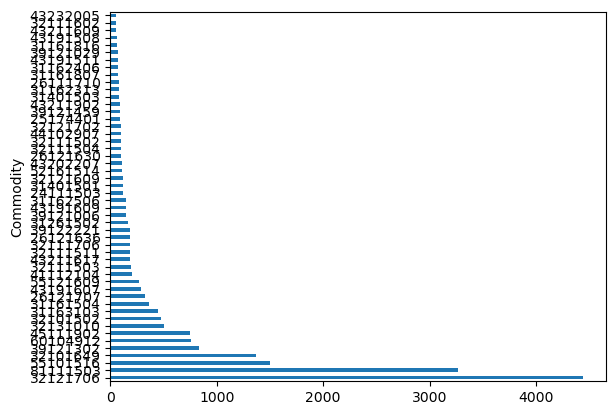

In [6]:
# get a dataframe of the top 50 Commodity CODES
y_top_50 = df6['Commodity'].value_counts().head(50)
df7 = df6[df6['Commodity'].isin(y_top_50.index.tolist())]
df7['Commodity'].value_counts().plot(kind='barh')

len(df7)

In [7]:
# Use label encoder to encode the Family CODES
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df7['Commodity'])
# y_decoded = label_encoder.inverse_transform(y_encoded)


In [8]:
tfidf_vectorizer = TfidfVectorizer()
X = tfidf_vectorizer.fit_transform(df7['Product_Description'])
X.shape


(19720, 24064)

In [9]:
tfidf_vectors = tfidf_vectorizer.inverse_transform(X)
df7['TF-IDF'] = list(tfidf_vectors)
df7 


,Product ID,DESCRIPTIONS,UNSPSC CODES,UNSPSC Code Description,ProductID_Type,TOKENS,Product_Description,Segment,Family,Class,Commodity,TF-IDF
0,0,set up sheet for ccx600 d,55101516,Operation or instruction manuals,numeric,"[set, sheet, ccx]","0,set up sheet for ccx600 d",55,5510,551015,55101516,"[ccx600, for, sheet, up, set]"
1,1000.004,"res, 270 ohm, cf, 1/8 w, 5%",32121706,Resistor or capacito,float,"[res, ohm, cf]","1000.004,res, 270 ohm, cf, 1/8 w, 5%",32,3212,321217,32121706,"[cf, ohm, 270, res, 004, 1000]"
2,1000.005,"res, 200 ohm, cf, 1/8 w, 5%",32121706,Resistor or capacito,float,"[res, ohm, cf]","1000.005,res, 200 ohm, cf, 1/8 w, 5%",32,3212,321217,32121706,"[200, 005, cf, ohm, res, 1000]"
3,1000.06,"res, 56k, cf, 1/8 w, 5%",32121706,Resistor or capacito,float,"[res, cf]","1000.06,res, 56k, cf, 1/8 w, 5%",32,3212,321217,32121706,"[56k, 06, cf, res, 1000]"
4,1000.075,"res, 100k, cf, 1/8 w, 5%",32121706,Resistor or capacito,float,"[res, cf]","1000.075,res, 100k, cf, 1/8 w, 5%",32,3212,321217,32121706,"[100k, 075, cf, res, 1000]"
...,...,...,...,...,...,...,...,...,...,...,...,...
25167,z462358-14f,"36k,5%,1/16w,0402,lf",32121706,Resistor or capacito,hyphenated,[lf],"z462358-14f,36k,5%,1/16w,0402,lf",32,3212,321217,32121706,"[14f, z462358, 36k, 0402, 16w, lf]"
25168,z462358-42f,"res,1/16w,510k ohms,5%,0402",32121706,Resistor or capacito,hyphenated,"[res, ohms]","z462358-42f,res,1/16w,510k ohms,5%,0402",32,3212,321217,32121706,"[42f, z462358, 510k, ohms, 0402, 16w, res]"
25169,z468610-04f,"c0g,15pf±025pf,50v,0201,lf",32121706,Resistor or capacito,hyphenated,"[pf±, pf, lf]","z468610-04f,c0g,15pf±025pf,50v,0201,lf",32,3212,321217,32121706,"[04f, z468610, 025pf, c0g, 15pf, 0201, lf, 50v]"
25170,z480086-01f,"side,actuated,16n,smd",39122221,Switch part or acces,hyphenated,"[side, actuated, smd]","z480086-01f,side,actuated,16n,smd",39,3912,391222,39122221,"[actuated, z480086, 01f, 16n, side, smd]"


In [10]:
# split X and y_encoded into training test and validation sets
X_train_enc, X_test_enc, y_train_enc, y_test_enc = train_test_split(X, y_encoded, test_size=0.1, random_state=42)
X_train_enc, X_val_enc, y_train_enc, y_val_enc = train_test_split(X_train_enc, y_train_enc, test_size=0.1, random_state=42)


In [11]:
# convert the true labels from  encoded format to class labels
y_test_labels =  label_encoder.inverse_transform(y_test_enc)

In [12]:
# # create the SMOTE object
smote = SMOTE()

# # fit and apply SMOTE to the one-hot-encoded training data
X_train_smote_enc, y_train_smote_enc = smote.fit_resample(X_train_enc, y_train_enc)

# # print the shape of the new training data
print('Shape of X_train_count_smote:', X_train_smote_enc.shape)
print('Shape of y_train_smote:', y_train_smote_enc.shape)


Shape of X_train_count_smote: (181950, 24064)
Shape of y_train_smote: (181950,)


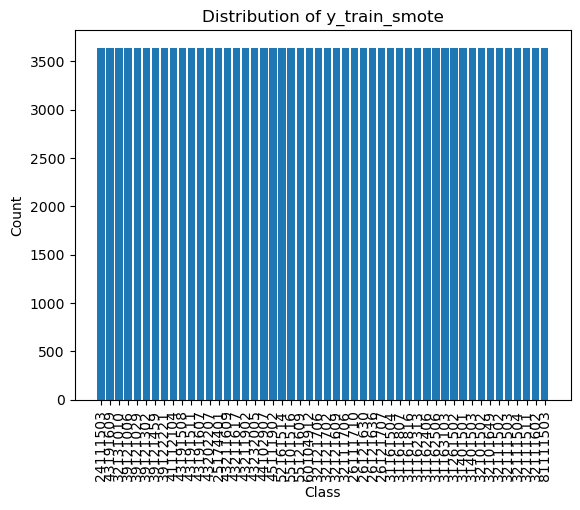

In [13]:
# import pandas as pd
# import matplotlib.pyplot as plt

# # create a dataframe of the class counts
class_counts = pd.DataFrame( label_encoder.inverse_transform(y_train_smote_enc), columns=['class']).value_counts().reset_index(name='count')

# plot the class counts as a bar chart
plt.bar(class_counts['class'], class_counts['count'])
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Distribution of y_train_smote')
plt.xticks(rotation=90)
plt.show();


In [14]:
# default model callback settings

def create_checkpoint(model_name):
    return ModelCheckpoint(
        filepath=model_name,
        mode='min',
        save_best_only=True,
        save_weights_only=False,
        monitor='val_loss',
        verbose=1
    )

early_stopping = EarlyStopping(patience=10, restore_best_weights=True,monitor='val_loss')


In [18]:
k.clear_session()
model_01 = Sequential()
model_01.add(Dense(64, input_shape=(X_train_smote_enc.shape[1],), activation='relu')) # 64 neurons in first layer
# add dropout layer for input layer
model_01.add(Dropout(0.5))
model_01.add(Dense(50, activation='softmax'))
model_01.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model_01.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                1540160   
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 50)                3250      
                                                                 
Total params: 1,543,410
Trainable params: 1,543,410
Non-trainable params: 0
_________________________________________________________________


In [19]:
history_01 = model_01.fit(X_train_enc.toarray(), y_train_enc, validation_data=(X_val_enc.toarray(), y_val_enc), epochs=100, batch_size=64,
        callbacks=[create_checkpoint('best_model_01_tfidf_64_enc.h5'),early_stopping], verbose=1)


Epoch 1/100
246/250 [============================>.] - ETA: 0s - loss: 2.8491 - accuracy: 0.4138
Epoch 1: val_loss improved from inf to 1.85785, saving model to best_model_01_tfidf_64_enc.h5
250/250 [==============================] - 2s 3ms/step - loss: 2.8363 - accuracy: 0.4161 - val_loss: 1.8579 - val_accuracy: 0.5983
Epoch 2/100
235/250 [===========================>..] - ETA: 0s - loss: 1.5065 - accuracy: 0.6691
Epoch 2: val_loss improved from 1.85785 to 1.12107, saving model to best_model_01_tfidf_64_enc.h5
250/250 [==============================] - 1s 3ms/step - loss: 1.4906 - accuracy: 0.6724 - val_loss: 1.1211 - val_accuracy: 0.7566
Epoch 3/100
236/250 [===========================>..] - ETA: 0s - loss: 0.9831 - accuracy: 0.7738
Epoch 3: val_loss improved from 1.12107 to 0.77783, saving model to best_model_01_tfidf_64_enc.h5
250/250 [==============================] - 1s 2ms/step - loss: 0.9743 - accuracy: 0.7765 - val_loss: 0.7778 - val_accuracy: 0.8366
Epoch 4/100
248/250 [=====

In [22]:
# make predictions on the test data
pred_nn = model_01.predict(X_test_enc.toarray())

# convert the predictions from  encoded format to class labels
pred_nn_labels = label_encoder.inverse_transform(np.argmax(pred_nn, axis=1))

# generate a classification report
print_validation_report(y_test_labels, pred_nn_labels)


62/62 [==============================] - 0s 2ms/step
Classification Report
              precision    recall  f1-score   support

    24111503       0.92      1.00      0.96        11
    25174401       1.00      1.00      1.00         6
    26111710       1.00      1.00      1.00         5
    26121630       0.67      0.60      0.63        10
    26121636       1.00      0.93      0.96        14
    26121707       0.90      0.96      0.93        28
    31161504       0.98      0.98      0.98        53
    31161807       1.00      0.75      0.86        12
    31161816       1.00      0.78      0.88         9
    31162313       0.71      0.83      0.77         6
    31162406       1.00      0.80      0.89        10
    31162506       1.00      1.00      1.00        14
    31163103       0.96      0.98      0.97        47
    31261502       0.93      1.00      0.97        14
    31401501       0.94      1.00      0.97        15
    31401503       1.00      1.00      1.00         8
    32

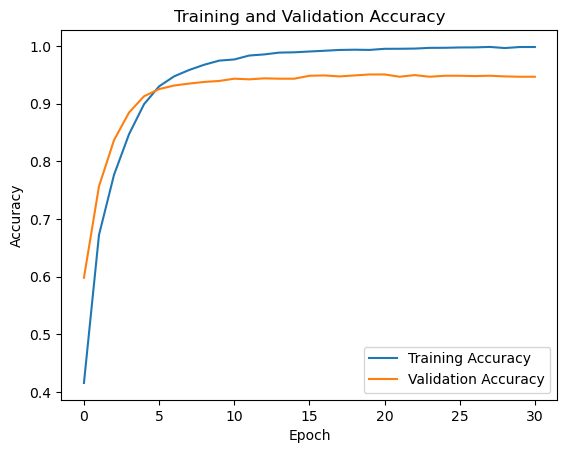

In [25]:
# plot the training and validation loss
plt.plot(history_01.history['accuracy'])
plt.plot(history_01.history['val_accuracy'])
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.show();

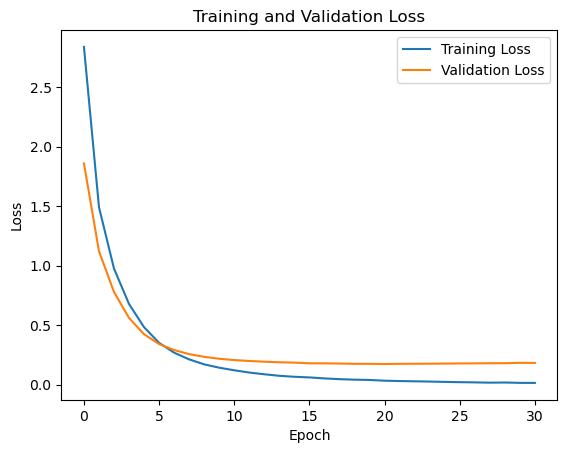

In [26]:
# plot the training and validation loss
plt.plot(history_01.history['loss'])
plt.plot(history_01.history['val_loss'])
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.show();


In [28]:
len(y_train_enc)


15973

In [43]:
k.clear_session()
model_02 = Sequential()
model_02.add(Dense(128, input_shape=(X_train_smote_enc.shape[1],), activation='relu')) # 128 neurons in first layer
model_02.add(Dropout(0.5))
model_02.add(Dense(50, activation='softmax'))
model_02.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model_02.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               3080320   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 50)                6450      
                                                                 
Total params: 3,086,770
Trainable params: 3,086,770
Non-trainable params: 0
_________________________________________________________________


In [44]:
history_02 = model_02.fit(X_train_enc.toarray(), y_train_enc, validation_data=(X_val_enc.toarray(), y_val_enc), epochs=100, batch_size=64,
        callbacks=[create_checkpoint('best_model_02_tfidf_128_enc.h5'),early_stopping], verbose=1)


Epoch 1/100
250/250 [==============================] - ETA: 0s - loss: 2.5134 - accuracy: 0.4969
Epoch 1: val_loss improved from inf to 1.44098, saving model to best_model_02_tfidf_128_enc.h5
250/250 [==============================] - 1s 3ms/step - loss: 2.5134 - accuracy: 0.4969 - val_loss: 1.4410 - val_accuracy: 0.6901
Epoch 2/100
244/250 [============================>.] - ETA: 0s - loss: 1.0850 - accuracy: 0.7622
Epoch 2: val_loss improved from 1.44098 to 0.77895, saving model to best_model_02_tfidf_128_enc.h5
250/250 [==============================] - 1s 2ms/step - loss: 1.0788 - accuracy: 0.7639 - val_loss: 0.7790 - val_accuracy: 0.8355
Epoch 3/100
235/250 [===========================>..] - ETA: 0s - loss: 0.5950 - accuracy: 0.8794
Epoch 3: val_loss improved from 0.77895 to 0.48169, saving model to best_model_02_tfidf_128_enc.h5
250/250 [==============================] - 1s 2ms/step - loss: 0.5865 - accuracy: 0.8807 - val_loss: 0.4817 - val_accuracy: 0.9048
Epoch 4/100
249/250 [==

In [45]:
# # make predictions on the test data
pred_nn = model_02.predict(X_test_enc.toarray())

# # convert the predictions from  encoded format to class labels
pred_nn_labels = label_encoder.inverse_transform(np.argmax(pred_nn, axis=1))

# generate a classification report
print_validation_report(y_test_labels, pred_nn_labels)


62/62 [==============================] - 0s 2ms/step
Classification Report
              precision    recall  f1-score   support

    24111503       0.92      1.00      0.96        11
    25174401       1.00      1.00      1.00         6
    26111710       1.00      1.00      1.00         5
    26121630       0.75      0.60      0.67        10
    26121636       1.00      0.93      0.96        14
    26121707       0.93      0.96      0.95        28
    31161504       1.00      0.98      0.99        53
    31161807       1.00      0.83      0.91        12
    31161816       1.00      0.89      0.94         9
    31162313       0.71      0.83      0.77         6
    31162406       1.00      0.80      0.89        10
    31162506       1.00      1.00      1.00        14
    31163103       0.98      0.98      0.98        47
    31261502       0.93      1.00      0.97        14
    31401501       0.94      1.00      0.97        15
    31401503       1.00      1.00      1.00         8
    32

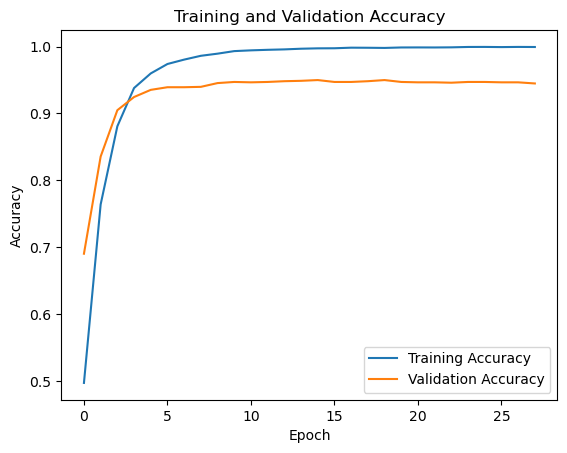

In [46]:
# plot the training and validation loss
plt.plot(history_02.history['accuracy'])
plt.plot(history_02.history['val_accuracy'])
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.show();

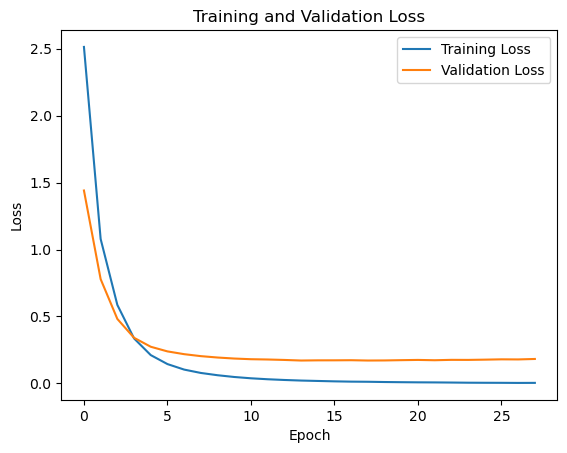

In [47]:
# plot the training and validation loss
plt.plot(history_02.history['loss'])
plt.plot(history_02.history['val_loss'])
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.show();


In [34]:
k.clear_session()
model_03 = Sequential()
model_03.add(Dense(256, input_shape=(X_train_smote_enc.shape[1],), activation='relu')) # 256 neurons in first layer
model_03.add(Dropout(0.5))
model_03.add(Dense(50, activation='softmax'))
model_03.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model_03.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               6160640   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 50)                12850     
                                                                 
Total params: 6,173,490
Trainable params: 6,173,490
Non-trainable params: 0
_________________________________________________________________


In [35]:
history_03 = model_03.fit(X_train_enc.toarray(), y_train_enc, validation_data=(X_val_enc.toarray(), y_val_enc), epochs=100, batch_size=64,
       callbacks=[create_checkpoint('best_model_03_tfidf_256_enc.h5'),early_stopping], verbose=1)


Epoch 1/100
231/250 [==========================>...] - ETA: 0s - loss: 2.2736 - accuracy: 0.5336
Epoch 1: val_loss improved from inf to 1.08740, saving model to best_model_03_tfidf_256_enc.h5
250/250 [==============================] - 1s 3ms/step - loss: 2.1893 - accuracy: 0.5495 - val_loss: 1.0874 - val_accuracy: 0.7628
Epoch 2/100
238/250 [===========================>..] - ETA: 0s - loss: 0.7356 - accuracy: 0.8528
Epoch 2: val_loss improved from 1.08740 to 0.50256, saving model to best_model_03_tfidf_256_enc.h5
250/250 [==============================] - 1s 3ms/step - loss: 0.7245 - accuracy: 0.8556 - val_loss: 0.5026 - val_accuracy: 0.9020
Epoch 3/100
240/250 [===========================>..] - ETA: 0s - loss: 0.3096 - accuracy: 0.9410
Epoch 3: val_loss improved from 0.50256 to 0.31233, saving model to best_model_03_tfidf_256_enc.h5
250/250 [==============================] - 1s 2ms/step - loss: 0.3072 - accuracy: 0.9413 - val_loss: 0.3123 - val_accuracy: 0.9301
Epoch 4/100
244/250 [==

In [36]:
# # make predictions on the test data
pred_nn = model_03.predict(X_test_enc.toarray())

# # convert the predictions from  encoded format to class labels
pred_nn_labels = label_encoder.inverse_transform(np.argmax(pred_nn, axis=1))

# generate a classification report
print_validation_report(y_test_labels, pred_nn_labels)


62/62 [==============================] - 0s 1ms/step
Classification Report
              precision    recall  f1-score   support

    24111503       0.92      1.00      0.96        11
    25174401       1.00      1.00      1.00         6
    26111710       1.00      1.00      1.00         5
    26121630       0.75      0.60      0.67        10
    26121636       1.00      0.93      0.96        14
    26121707       0.90      0.96      0.93        28
    31161504       1.00      0.98      0.99        53
    31161807       1.00      0.83      0.91        12
    31161816       1.00      0.89      0.94         9
    31162313       0.71      0.83      0.77         6
    31162406       1.00      0.80      0.89        10
    31162506       1.00      1.00      1.00        14
    31163103       0.96      0.98      0.97        47
    31261502       0.93      1.00      0.97        14
    31401501       0.94      1.00      0.97        15
    31401503       1.00      0.88      0.93         8
    32

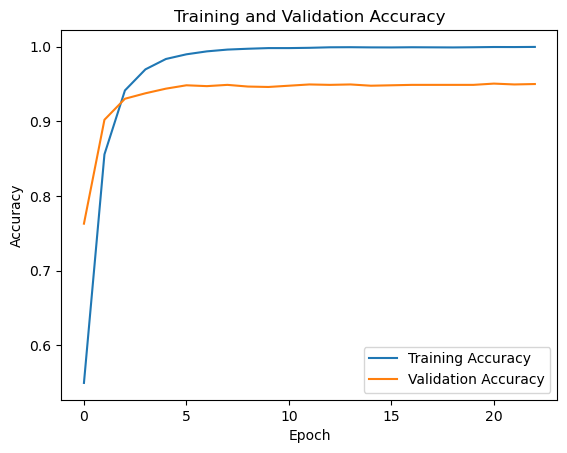

In [37]:
# plot the training and validation loss
plt.plot(history_03.history['accuracy'])
plt.plot(history_03.history['val_accuracy'])
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.show();

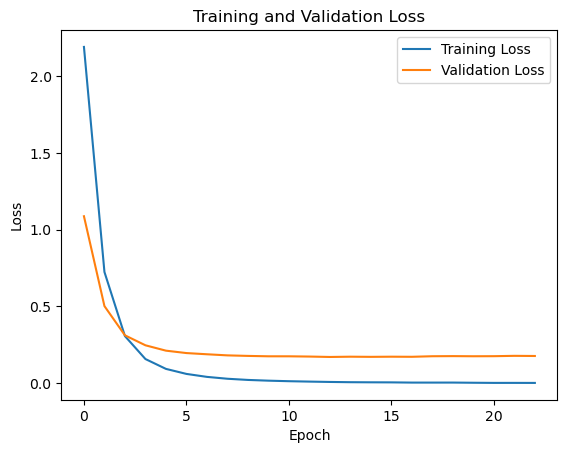

In [38]:
# plot the training and validation loss
plt.plot(history_03.history['loss'])
plt.plot(history_03.history['val_loss'])
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.show();


In [39]:
k.clear_session()
model_04 = Sequential()
model_04.add(Dense(512, input_shape=(X_train_smote_enc.shape[1],), activation='relu')) # 512 neurons in first layer
model_04.add(Dropout(0.5))
model_04.add(Dense(50, activation='softmax'))
model_04.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model_04.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               12321280  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 50)                25650     
                                                                 
Total params: 12,346,930
Trainable params: 12,346,930
Non-trainable params: 0
_________________________________________________________________


In [40]:
history_04 = model_04.fit(X_train_enc.toarray(), y_train_enc, validation_data=(X_val_enc.toarray(), y_val_enc), epochs=100, batch_size=64,
        callbacks=[create_checkpoint('best_model_04_tfidf_512_enc.h5'),early_stopping], verbose=1)


Epoch 1/100
242/250 [============================>.] - ETA: 0s - loss: 1.9085 - accuracy: 0.6067
Epoch 1: val_loss improved from inf to 0.79028, saving model to best_model_04_tfidf_512_enc.h5
250/250 [==============================] - 1s 4ms/step - loss: 1.8792 - accuracy: 0.6125 - val_loss: 0.7903 - val_accuracy: 0.8411
Epoch 2/100
250/250 [==============================] - ETA: 0s - loss: 0.4490 - accuracy: 0.9158
Epoch 2: val_loss improved from 0.79028 to 0.33701, saving model to best_model_04_tfidf_512_enc.h5
250/250 [==============================] - 1s 3ms/step - loss: 0.4490 - accuracy: 0.9158 - val_loss: 0.3370 - val_accuracy: 0.9239
Epoch 3/100
247/250 [============================>.] - ETA: 0s - loss: 0.1600 - accuracy: 0.9679
Epoch 3: val_loss improved from 0.33701 to 0.23872, saving model to best_model_04_tfidf_512_enc.h5
250/250 [==============================] - 1s 3ms/step - loss: 0.1600 - accuracy: 0.9678 - val_loss: 0.2387 - val_accuracy: 0.9397
Epoch 4/100
246/250 [==

In [41]:
# # make predictions on the test data
pred_nn = model_04.predict(X_test_enc.toarray())

# # convert the predictions from  encoded format to class labels
pred_nn_labels = label_encoder.inverse_transform(np.argmax(pred_nn, axis=1))

# generate a classification report
print_validation_report(y_test_labels, pred_nn_labels)

62/62 [==============================] - 0s 1ms/step
Classification Report
              precision    recall  f1-score   support

    24111503       0.92      1.00      0.96        11
    25174401       1.00      1.00      1.00         6
    26111710       1.00      1.00      1.00         5
    26121630       0.75      0.60      0.67        10
    26121636       1.00      0.93      0.96        14
    26121707       0.90      0.96      0.93        28
    31161504       1.00      0.98      0.99        53
    31161807       1.00      0.75      0.86        12
    31161816       1.00      0.89      0.94         9
    31162313       0.71      0.83      0.77         6
    31162406       1.00      0.80      0.89        10
    31162506       1.00      1.00      1.00        14
    31163103       0.98      1.00      0.99        47
    31261502       0.93      1.00      0.97        14
    31401501       0.94      1.00      0.97        15
    31401503       1.00      0.88      0.93         8
    32

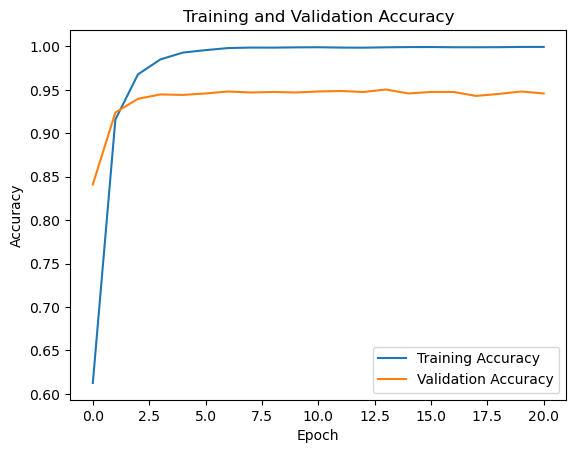

In [42]:
# plot the training and validation loss
plt.plot(history_04.history['accuracy'])
plt.plot(history_04.history['val_accuracy'])
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.show();

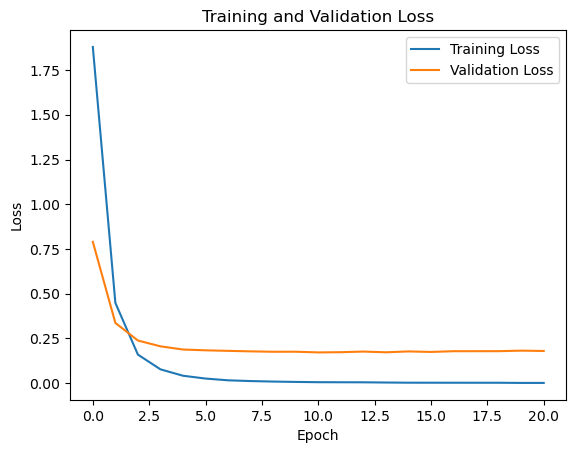

In [43]:
# plot the training and validation loss
plt.plot(history_04.history['loss'])
plt.plot(history_04.history['val_loss'])
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.show();

In [44]:
k.clear_session()
model_05 = Sequential()
model_05.add(Dense(1024, input_shape=(X_train_smote_enc.shape[1],), activation='relu')) # 1024 neurons in first layer
model_05.add(Dropout(0.5))
model_05.add(Dense(50, activation='softmax'))
model_05.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model_05.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              24642560  
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 50)                51250     
                                                                 
Total params: 24,693,810
Trainable params: 24,693,810
Non-trainable params: 0
_________________________________________________________________


In [45]:
history_05 = model_05.fit(X_train_enc.toarray(), y_train_enc, validation_data=(X_val_enc.toarray(), y_val_enc), epochs=100, batch_size=64,
#        callbacks=[model_checkpoint_05,early_stopping_05], verbose=1)
        callbacks=[create_checkpoint('best_model_05_tfidf_1024_enc.h5'),early_stopping], verbose=1)


Epoch 1/100
250/250 [==============================] - ETA: 0s - loss: 1.5818 - accuracy: 0.6770
Epoch 1: val_loss improved from inf to 0.53307, saving model to best_model_05_tfidf_1024_enc.h5
250/250 [==============================] - 6s 24ms/step - loss: 1.5818 - accuracy: 0.6770 - val_loss: 0.5331 - val_accuracy: 0.8952
Epoch 2/100
250/250 [==============================] - ETA: 0s - loss: 0.2667 - accuracy: 0.9459
Epoch 2: val_loss improved from 0.53307 to 0.25013, saving model to best_model_05_tfidf_1024_enc.h5
250/250 [==============================] - 6s 23ms/step - loss: 0.2667 - accuracy: 0.9459 - val_loss: 0.2501 - val_accuracy: 0.9386
Epoch 3/100
250/250 [==============================] - ETA: 0s - loss: 0.0886 - accuracy: 0.9807
Epoch 3: val_loss improved from 0.25013 to 0.20147, saving model to best_model_05_tfidf_1024_enc.h5
250/250 [==============================] - 6s 23ms/step - loss: 0.0886 - accuracy: 0.9807 - val_loss: 0.2015 - val_accuracy: 0.9476
Epoch 4/100
250/2

In [46]:
# # make predictions on the test data
pred_nn = model_05.predict(X_test_enc.toarray())

# # convert the predictions from  encoded format to class labels
pred_nn_labels = label_encoder.inverse_transform(np.argmax(pred_nn, axis=1))

# generate a classification report
print_validation_report(y_test_labels, pred_nn_labels)


62/62 [==============================] - 1s 12ms/step
Classification Report
              precision    recall  f1-score   support

    24111503       0.92      1.00      0.96        11
    25174401       1.00      1.00      1.00         6
    26111710       1.00      1.00      1.00         5
    26121630       0.67      0.60      0.63        10
    26121636       1.00      0.93      0.96        14
    26121707       0.90      0.96      0.93        28
    31161504       1.00      0.98      0.99        53
    31161807       1.00      0.83      0.91        12
    31161816       1.00      0.89      0.94         9
    31162313       0.71      0.83      0.77         6
    31162406       1.00      0.80      0.89        10
    31162506       1.00      1.00      1.00        14
    31163103       0.98      1.00      0.99        47
    31261502       0.93      1.00      0.97        14
    31401501       0.94      1.00      0.97        15
    31401503       1.00      1.00      1.00         8
    3

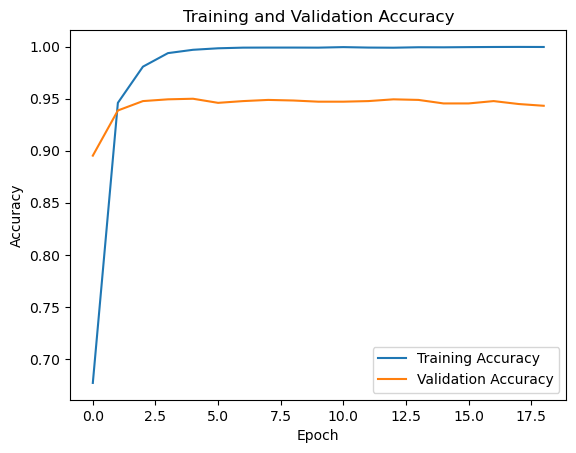

In [47]:
#  plot the training and validation loss
plt.plot(history_05.history['accuracy'])
plt.plot(history_05.history['val_accuracy'])
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.show();

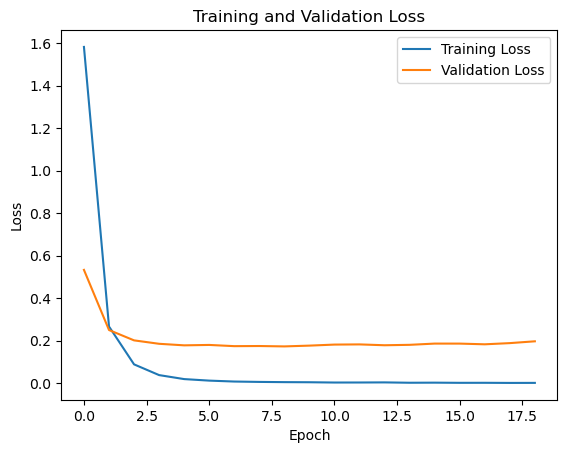

In [48]:
# plot the training and validation loss
plt.plot(history_05.history['loss'])
plt.plot(history_05.history['val_loss'])
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.show();


In [15]:
k.clear_session()
model_06 = Sequential()
model_06.add(Dense(1536, input_shape=(X_train_smote_enc.shape[1],), activation='relu')) # 1536 neurons in first layer
model_06.add(Dropout(0.5))
model_06.add(Dense(50, activation='softmax'))
model_06.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model_06.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1536)              36963840  
                                                                 
 dropout (Dropout)           (None, 1536)              0         
                                                                 
 dense_1 (Dense)             (None, 50)                76850     
                                                                 
Total params: 37,040,690
Trainable params: 37,040,690
Non-trainable params: 0
_________________________________________________________________


In [16]:
history_06 = model_06.fit(X_train_enc.toarray(), y_train_enc, validation_data=(X_val_enc.toarray(), y_val_enc), epochs=100, batch_size=64,
        callbacks=[create_checkpoint('best_model_06_tfidf_1536_enc.h5'),early_stopping], verbose=1)


Epoch 1/100
238/250 [===========================>..] - ETA: 0s - loss: 1.4576 - accuracy: 0.6962
Epoch 1: val_loss improved from inf to 0.42454, saving model to best_model_06_tfidf_1536_enc.h5
250/250 [==============================] - 3s 8ms/step - loss: 1.4102 - accuracy: 0.7066 - val_loss: 0.4245 - val_accuracy: 0.9093
Epoch 2/100
250/250 [==============================] - ETA: 0s - loss: 0.1985 - accuracy: 0.9571
Epoch 2: val_loss improved from 0.42454 to 0.22029, saving model to best_model_06_tfidf_1536_enc.h5
250/250 [==============================] - 2s 6ms/step - loss: 0.1985 - accuracy: 0.9571 - val_loss: 0.2203 - val_accuracy: 0.9414
Epoch 3/100
238/250 [===========================>..] - ETA: 0s - loss: 0.0617 - accuracy: 0.9873
Epoch 3: val_loss improved from 0.22029 to 0.18723, saving model to best_model_06_tfidf_1536_enc.h5
250/250 [==============================] - 1s 6ms/step - loss: 0.0612 - accuracy: 0.9872 - val_loss: 0.1872 - val_accuracy: 0.9459
Epoch 4/100
237/250 

In [17]:
# # make predictions on the test data
pred_nn = model_06.predict(X_test_enc.toarray())

# # convert the predictions from  encoded format to class labels
pred_nn_labels = label_encoder.inverse_transform(np.argmax(pred_nn, axis=1))

# generate a classification report
print_validation_report(y_test_labels, pred_nn_labels)


62/62 [==============================] - 0s 1ms/step
Classification Report
              precision    recall  f1-score   support

    24111503       0.92      1.00      0.96        11
    25174401       1.00      1.00      1.00         6
    26111710       1.00      1.00      1.00         5
    26121630       0.67      0.60      0.63        10
    26121636       1.00      0.93      0.96        14
    26121707       0.87      0.96      0.92        28
    31161504       1.00      0.98      0.99        53
    31161807       1.00      0.83      0.91        12
    31161816       1.00      0.78      0.88         9
    31162313       0.71      0.83      0.77         6
    31162406       1.00      0.80      0.89        10
    31162506       1.00      1.00      1.00        14
    31163103       0.98      0.96      0.97        47
    31261502       0.93      1.00      0.97        14
    31401501       0.94      1.00      0.97        15
    31401503       1.00      0.88      0.93         8
    32

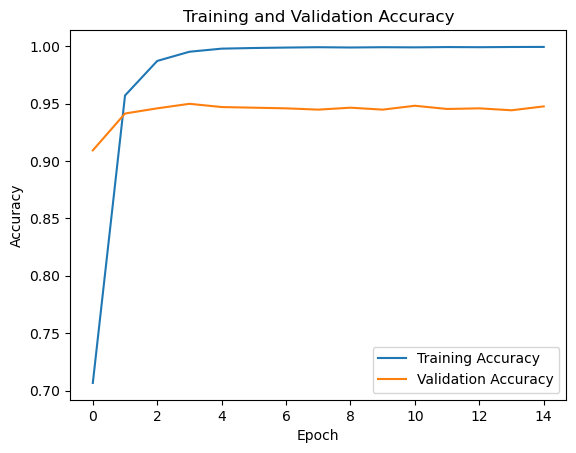

In [18]:
# plot the training and validation loss
plt.plot(history_06.history['accuracy'])
plt.plot(history_06.history['val_accuracy'])
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.show();

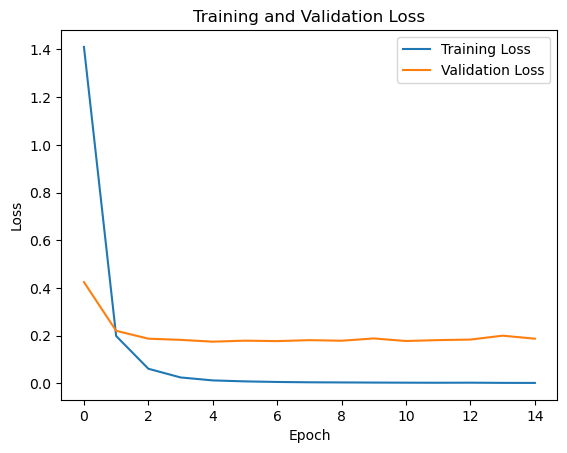

In [19]:
# plot the training and validation loss
plt.plot(history_06.history['loss'])
plt.plot(history_06.history['val_loss'])
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.show();


In [20]:
k.clear_session()
model_07 = Sequential()
model_07.add(Dense(2048, input_shape=(X_train_smote_enc.shape[1],), activation='relu')) # 2048 neurons in first layer
model_07.add(Dropout(0.5))
model_07.add(Dense(50, activation='softmax'))
model_07.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model_07.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2048)              49285120  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 50)                102450    
                                                                 
Total params: 49,387,570
Trainable params: 49,387,570
Non-trainable params: 0
_________________________________________________________________


In [21]:
history_07 = model_07.fit(X_train_enc.toarray(), y_train_enc, validation_data=(X_val_enc.toarray(), y_val_enc), epochs=100, batch_size=64,
        callbacks=[create_checkpoint('best_model_07_tfidf_2048_enc.h5'),early_stopping], verbose=1)


Epoch 1/100
242/250 [============================>.] - ETA: 0s - loss: 1.3411 - accuracy: 0.7219
Epoch 1: val_loss improved from inf to 0.35611, saving model to best_model_07_tfidf_2048_enc.h5
250/250 [==============================] - 2s 8ms/step - loss: 1.3122 - accuracy: 0.7278 - val_loss: 0.3561 - val_accuracy: 0.9228
Epoch 2/100
245/250 [============================>.] - ETA: 0s - loss: 0.1657 - accuracy: 0.9622
Epoch 2: val_loss improved from 0.35611 to 0.20649, saving model to best_model_07_tfidf_2048_enc.h5
250/250 [==============================] - 2s 7ms/step - loss: 0.1655 - accuracy: 0.9621 - val_loss: 0.2065 - val_accuracy: 0.9459
Epoch 3/100
247/250 [============================>.] - ETA: 0s - loss: 0.0482 - accuracy: 0.9894
Epoch 3: val_loss improved from 0.20649 to 0.18474, saving model to best_model_07_tfidf_2048_enc.h5
250/250 [==============================] - 2s 7ms/step - loss: 0.0482 - accuracy: 0.9892 - val_loss: 0.1847 - val_accuracy: 0.9459
Epoch 4/100
247/250 

In [22]:
# # make predictions on the test data
pred_nn = model_07.predict(X_test_enc.toarray())

# # convert the predictions from  encoded format to class labels
pred_nn_labels = label_encoder.inverse_transform(np.argmax(pred_nn, axis=1))

# generate a classification report
print_validation_report(y_test_labels, pred_nn_labels)


62/62 [==============================] - 0s 1ms/step
Classification Report
              precision    recall  f1-score   support

    24111503       0.92      1.00      0.96        11
    25174401       1.00      1.00      1.00         6
    26111710       1.00      1.00      1.00         5
    26121630       0.75      0.60      0.67        10
    26121636       1.00      0.93      0.96        14
    26121707       0.90      0.96      0.93        28
    31161504       1.00      0.98      0.99        53
    31161807       1.00      0.83      0.91        12
    31161816       1.00      0.89      0.94         9
    31162313       0.71      0.83      0.77         6
    31162406       1.00      0.90      0.95        10
    31162506       1.00      1.00      1.00        14
    31163103       0.98      1.00      0.99        47
    31261502       0.93      1.00      0.97        14
    31401501       0.94      1.00      0.97        15
    31401503       1.00      1.00      1.00         8
    32

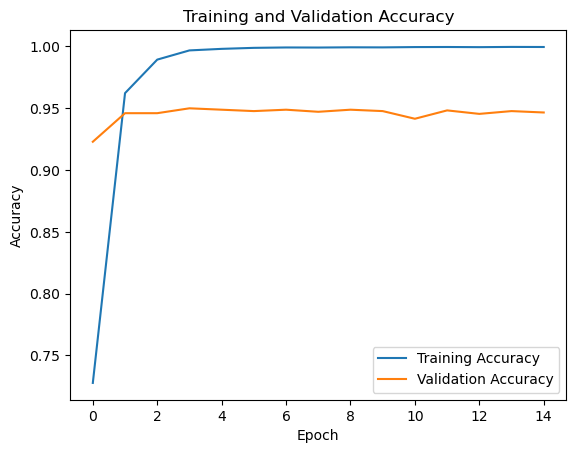

In [23]:
#  plot the training and validation loss
plt.plot(history_07.history['accuracy'])
plt.plot(history_07.history['val_accuracy'])
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.show();

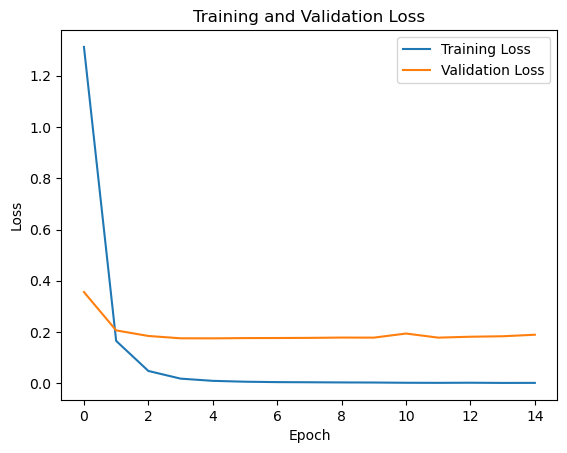

In [24]:
# plot the training and validation loss
plt.plot(history_07.history['loss'])
plt.plot(history_07.history['val_loss'])
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.show();


In [25]:
k.clear_session()
model_08 = Sequential()
model_08.add(Dense(128, input_shape=(X_train_smote_enc.shape[1],), activation='relu')) # 128 neurons in first layer
model_08.add(Dropout(0.5))
model_08.add(Dense(64, activation='relu')) # 64 neurons in second layer
model_08.add(Dropout(0.5))
model_08.add(Dense(50, activation='softmax'))
model_08.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model_08.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               3080320   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 50)                3250      
                                                                 
Total params: 3,091,826
Trainable params: 3,091,826
Non-trainable params: 0
_________________________________________________________________


In [26]:
history_08 = model_08.fit(X_train_enc.toarray(), y_train_enc, validation_data=(X_val_enc.toarray(), y_val_enc), epochs=100, batch_size=64,
        callbacks=[create_checkpoint('best_model_08_tfidf_128_64_enc.h5'),early_stopping], verbose=1)


Epoch 1/100
228/250 [==========================>...] - ETA: 0s - loss: 2.5718 - accuracy: 0.3810
Epoch 1: val_loss improved from inf to 1.44796, saving model to best_model_08_tfidf_128_64_enc.h5
250/250 [==============================] - 1s 3ms/step - loss: 2.4945 - accuracy: 0.3988 - val_loss: 1.4480 - val_accuracy: 0.6749
Epoch 2/100
238/250 [===========================>..] - ETA: 0s - loss: 1.2595 - accuracy: 0.6891
Epoch 2: val_loss improved from 1.44796 to 0.85947, saving model to best_model_08_tfidf_128_64_enc.h5
250/250 [==============================] - 1s 2ms/step - loss: 1.2482 - accuracy: 0.6922 - val_loss: 0.8595 - val_accuracy: 0.7882
Epoch 3/100
248/250 [============================>.] - ETA: 0s - loss: 0.8445 - accuracy: 0.7805
Epoch 3: val_loss improved from 0.85947 to 0.58348, saving model to best_model_08_tfidf_128_64_enc.h5
250/250 [==============================] - 1s 2ms/step - loss: 0.8439 - accuracy: 0.7808 - val_loss: 0.5835 - val_accuracy: 0.8552
Epoch 4/100
24

In [27]:
# # make predictions on the test data
pred_nn = model_08.predict(X_test_enc.toarray())

# # convert the predictions from  encoded format to class labels
pred_nn_labels = label_encoder.inverse_transform(np.argmax(pred_nn, axis=1))

# generate a classification report
print_validation_report(y_test_labels, pred_nn_labels)


62/62 [==============================] - 0s 2ms/step
Classification Report
              precision    recall  f1-score   support

    24111503       0.85      1.00      0.92        11
    25174401       1.00      1.00      1.00         6
    26111710       0.80      0.80      0.80         5
    26121630       0.38      0.30      0.33        10
    26121636       1.00      0.93      0.96        14
    26121707       0.87      0.96      0.92        28
    31161504       0.98      0.98      0.98        53
    31161807       1.00      0.75      0.86        12
    31161816       0.86      0.67      0.75         9
    31162313       0.83      0.83      0.83         6
    31162406       1.00      0.70      0.82        10
    31162506       1.00      0.93      0.96        14
    31163103       0.90      0.94      0.92        47
    31261502       0.93      1.00      0.97        14
    31401501       0.94      1.00      0.97        15
    31401503       1.00      0.75      0.86         8
    32

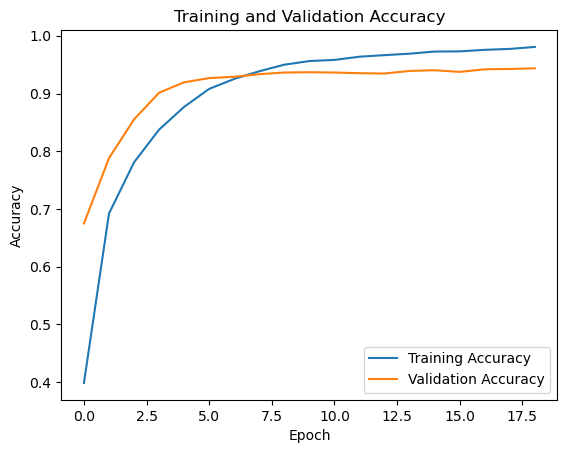

In [28]:
# plot the training and validation loss
plt.plot(history_08.history['accuracy'])
plt.plot(history_08.history['val_accuracy'])
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.show();

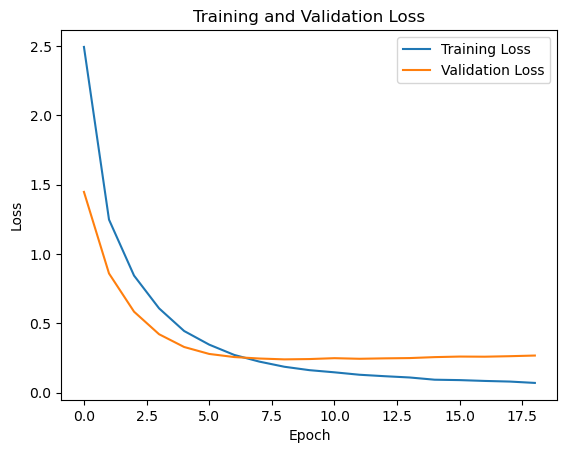

In [29]:
# plot the training and validation loss
plt.plot(history_08.history['loss'])
plt.plot(history_08.history['val_loss'])
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.show();


In [30]:
k.clear_session()
model_09 = Sequential()
model_09.add(Dense(512, input_shape=(X_train_smote_enc.shape[1],), activation='relu')) # 512 neurons in first layer
model_09.add(Dropout(0.5))
model_09.add(Dense(128, activation='relu')) # 128 neurons in second layer
model_09.add(Dropout(0.5))
model_09.add(Dense(50, activation='softmax'))
model_09.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model_09.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               12321280  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 50)                6450      
                                                                 
Total params: 12,393,394
Trainable params: 12,393,394
Non-trainable params: 0
_________________________________________________________________


In [31]:
history_09 = model_09.fit(X_train_enc.toarray(), y_train_enc, validation_data=(X_val_enc.toarray(), y_val_enc), epochs=100, batch_size=64,
        callbacks=[create_checkpoint('best_model_09_tfidf_512_128_enc.h5'),early_stopping], verbose=1)


Epoch 1/100
235/250 [===========================>..] - ETA: 0s - loss: 1.9316 - accuracy: 0.5429
Epoch 1: val_loss improved from inf to 0.83621, saving model to best_model_09_tfidf_512_128_enc.h5
250/250 [==============================] - 1s 5ms/step - loss: 1.8732 - accuracy: 0.5563 - val_loss: 0.8362 - val_accuracy: 0.8000
Epoch 2/100
234/250 [===========================>..] - ETA: 0s - loss: 0.6116 - accuracy: 0.8541
Epoch 2: val_loss improved from 0.83621 to 0.34484, saving model to best_model_09_tfidf_512_128_enc.h5
250/250 [==============================] - 1s 4ms/step - loss: 0.5978 - accuracy: 0.8571 - val_loss: 0.3448 - val_accuracy: 0.9223
Epoch 3/100
240/250 [===========================>..] - ETA: 0s - loss: 0.2374 - accuracy: 0.9447
Epoch 3: val_loss improved from 0.34484 to 0.22812, saving model to best_model_09_tfidf_512_128_enc.h5
250/250 [==============================] - 1s 3ms/step - loss: 0.2379 - accuracy: 0.9443 - val_loss: 0.2281 - val_accuracy: 0.9408
Epoch 4/100

In [32]:
# # make predictions on the test data
pred_nn = model_09.predict(X_test_enc.toarray())

# # convert the predictions from  encoded format to class labels
pred_nn_labels = label_encoder.inverse_transform(np.argmax(pred_nn, axis=1))

# generate a classification report
print_validation_report(y_test_labels, pred_nn_labels)


62/62 [==============================] - 0s 1ms/step
Classification Report
              precision    recall  f1-score   support

    24111503       0.92      1.00      0.96        11
    25174401       1.00      1.00      1.00         6
    26111710       1.00      1.00      1.00         5
    26121630       0.62      0.50      0.56        10
    26121636       1.00      0.93      0.96        14
    26121707       0.90      0.93      0.91        28
    31161504       1.00      0.98      0.99        53
    31161807       0.91      0.83      0.87        12
    31161816       1.00      0.89      0.94         9
    31162313       0.62      0.83      0.71         6
    31162406       0.89      0.80      0.84        10
    31162506       0.93      1.00      0.97        14
    31163103       0.96      0.91      0.93        47
    31261502       0.93      1.00      0.97        14
    31401501       0.94      1.00      0.97        15
    31401503       1.00      0.75      0.86         8
    32

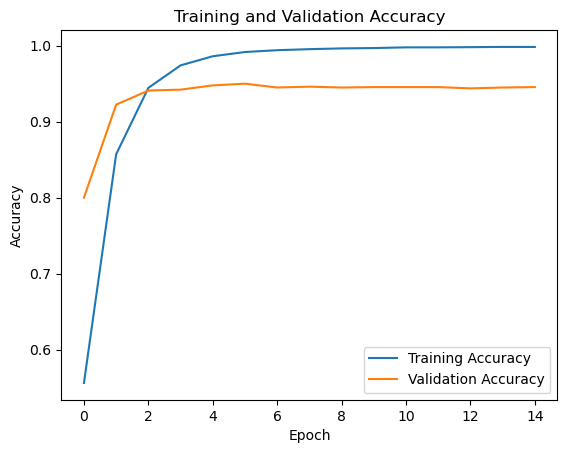

In [33]:
#  plot the training and validation loss
plt.plot(history_09.history['accuracy'])
plt.plot(history_09.history['val_accuracy'])
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.show();

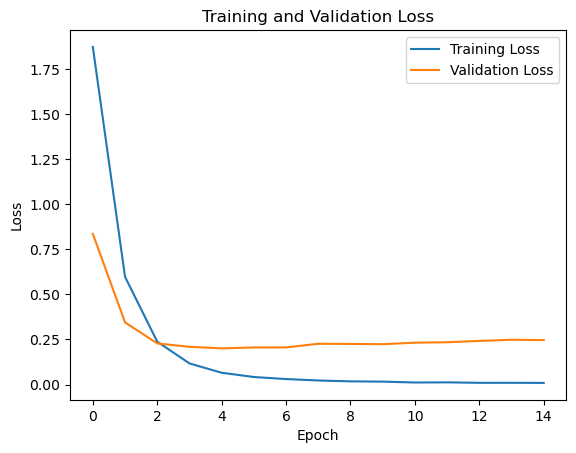

In [34]:
# plot the training and validation loss
plt.plot(history_09.history['loss'])
plt.plot(history_09.history['val_loss'])
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.show();


In [35]:
k.clear_session()
model_10 = Sequential()
model_10.add(Dense(1024, input_shape=(X_train_smote_enc.shape[1],), activation='relu')) # 1024 neurons in first layer
model_10.add(Dropout(0.5))
model_10.add(Dense(256, activation='relu')) # 256 neurons in second layer
model_10.add(Dropout(0.5))
model_10.add(Dense(50, activation='softmax'))
model_10.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model_10.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              24642560  
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 256)               262400    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 50)                12850     
                                                                 
Total params: 24,917,810
Trainable params: 24,917,810
Non-trainable params: 0
_________________________________________________________________


In [36]:
history_10 = model_10.fit(X_train_enc.toarray(), y_train_enc, validation_data=(X_val_enc.toarray(), y_val_enc), epochs=100, batch_size=64,
        callbacks=[create_checkpoint('best_model_10_tfidf_1024_256_enc.h5'),early_stopping], verbose=1)


Epoch 1/100
244/250 [============================>.] - ETA: 0s - loss: 1.6028 - accuracy: 0.6215
Epoch 1: val_loss improved from inf to 0.56336, saving model to best_model_10_tfidf_1024_256_enc.h5
250/250 [==============================] - 2s 6ms/step - loss: 1.5796 - accuracy: 0.6269 - val_loss: 0.5634 - val_accuracy: 0.8721
Epoch 2/100
245/250 [============================>.] - ETA: 0s - loss: 0.3236 - accuracy: 0.9222
Epoch 2: val_loss improved from 0.56336 to 0.22456, saving model to best_model_10_tfidf_1024_256_enc.h5
250/250 [==============================] - 1s 5ms/step - loss: 0.3213 - accuracy: 0.9229 - val_loss: 0.2246 - val_accuracy: 0.9392
Epoch 3/100
243/250 [============================>.] - ETA: 0s - loss: 0.0954 - accuracy: 0.9762
Epoch 3: val_loss improved from 0.22456 to 0.20540, saving model to best_model_10_tfidf_1024_256_enc.h5
250/250 [==============================] - 1s 5ms/step - loss: 0.0956 - accuracy: 0.9761 - val_loss: 0.2054 - val_accuracy: 0.9408
Epoch 4/

In [37]:
# # make predictions on the test data
pred_nn = model_10.predict(X_test_enc.toarray())

# # convert the predictions from  encoded format to class labels
pred_nn_labels = label_encoder.inverse_transform(np.argmax(pred_nn, axis=1))

# generate a classification report
print_validation_report(y_test_labels, pred_nn_labels)


62/62 [==============================] - 0s 1ms/step
Classification Report
              precision    recall  f1-score   support

    24111503       0.92      1.00      0.96        11
    25174401       1.00      0.83      0.91         6
    26111710       1.00      1.00      1.00         5
    26121630       0.45      0.50      0.48        10
    26121636       1.00      0.93      0.96        14
    26121707       0.87      0.96      0.92        28
    31161504       1.00      0.98      0.99        53
    31161807       1.00      0.83      0.91        12
    31161816       0.89      0.89      0.89         9
    31162313       0.71      0.83      0.77         6
    31162406       1.00      0.70      0.82        10
    31162506       0.93      1.00      0.97        14
    31163103       0.98      1.00      0.99        47
    31261502       0.93      1.00      0.97        14
    31401501       0.94      1.00      0.97        15
    31401503       1.00      0.88      0.93         8
    32

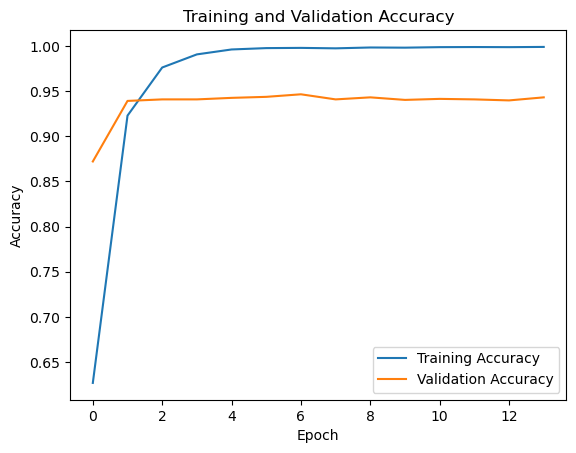

In [38]:
# plot the training and validation loss
plt.plot(history_10.history['accuracy'])
plt.plot(history_10.history['val_accuracy'])
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.show();

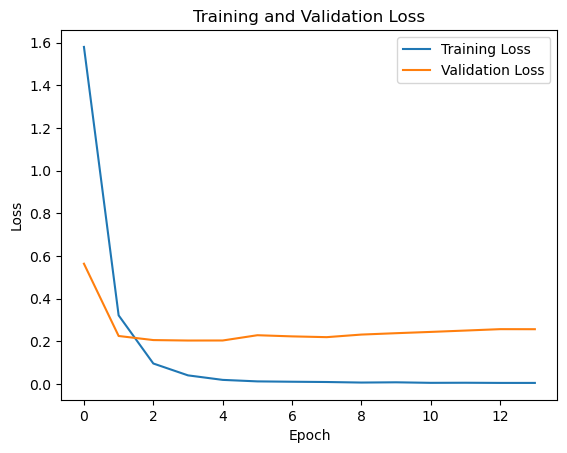

In [39]:
# plot the training and validation loss
plt.plot(history_10.history['loss'])
plt.plot(history_10.history['val_loss'])
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.show();
